In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, ttest_ind
from scipy.stats import kruskal
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings("ignore")

# Предварительныя обработка

*Подгружаем готовые данные*

In [3]:
df = pd.read_csv('/content/Housing.csv')
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


* `price` цена домов (целевой признак)
* `area`  площадь дома в кв. м.
* `bedrooms`  количество спален
* `bathrooms`  количество ванных комнат
* `stories`  количество этажей
* `mainroad`  есть ли поблизости главная дорога
* `guestroom`  оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* `basement`  наличие подвала
* `hotwaterheating`  наличие системы горячего водоснабжения
* `airconditioning`  наличие кондиционера
* `parking`  количество парковочных мест
* `prefarea`  указывает, расположен ли дом в предпочтительном районе
* `furnishingstatus`  указывает наличие мебели (с мебелью/частично с мебелью/без мебели)

*Выводим количество пропущенных значений в каждом столбце DataFrame df в порядке убывания. Затем подсчитываем количество дубликатов строк в DataFrame*

In [5]:
df.isna().sum().sort_values(ascending=False)

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

In [6]:
df.duplicated().sum()

0

*Преобразоваем значения в столбце "price" в миллионы единиц для удобства чтения и анализа, а затем вызываем метод describe() для получения описательной статистики нового состояния DataFrame*

In [7]:
df['price'] = df['price'] / (10 ** 6) # Для удобства переведем в млн. ед.
df.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000,6360.000000,3.000000,2.000000,2.000000,1.000000
max,13.300000,16200.000000,6.000000,4.000000,4.000000,3.000000


*Получаем описательную статистику, такую как количество уникальных значений, наиболее часто встречающееся значение и количество его вхождений*

In [8]:
df.describe(include='object')

,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea,furnishingstatus
count,545,545,545,545,545,545,545
unique,2,2,2,2,2,2,3
top,yes,no,no,no,no,no,semi-furnished
freq,468,448,354,520,373,417,227


*По описательной статистике видно, что по целевому признаку и площади дома есть выбросы*

 **Вывод:** В данных не обнаружено пропусков и дубликатов, а также все столбцы соответствуют типам данных.

# Визуализация

*Посмотрим гистограмму количества продаваемых квартир в зависимости от их стоимости*

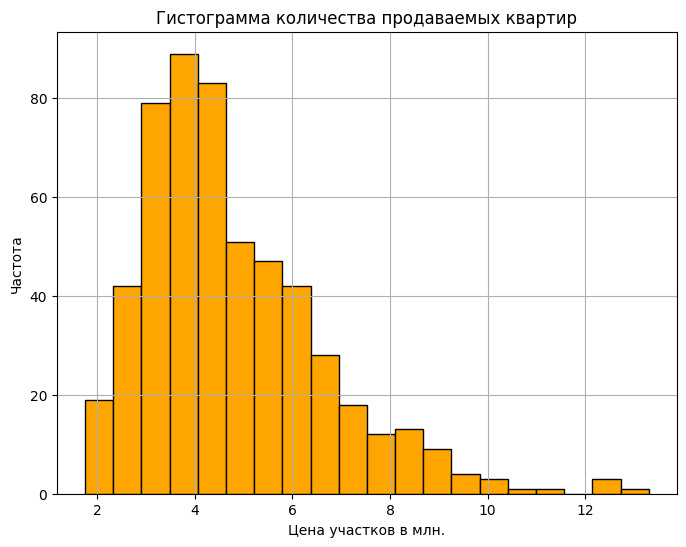

In [9]:
plt.figure(figsize=(8, 6))
plt.hist(df['price'], bins=20, color='orange', edgecolor='black')
plt.title('Гистограмма количества продаваемых квартир')
plt.xlabel('Цена участков в млн.')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

**Вывод:** Распределение цены смещено влево и имеет хвост

*Далее посмотрим, как переменные коррелируют с целевой переменной с помощью матрицы облаков рассеивания*

<Figure size 1200x1000 with 0 Axes>

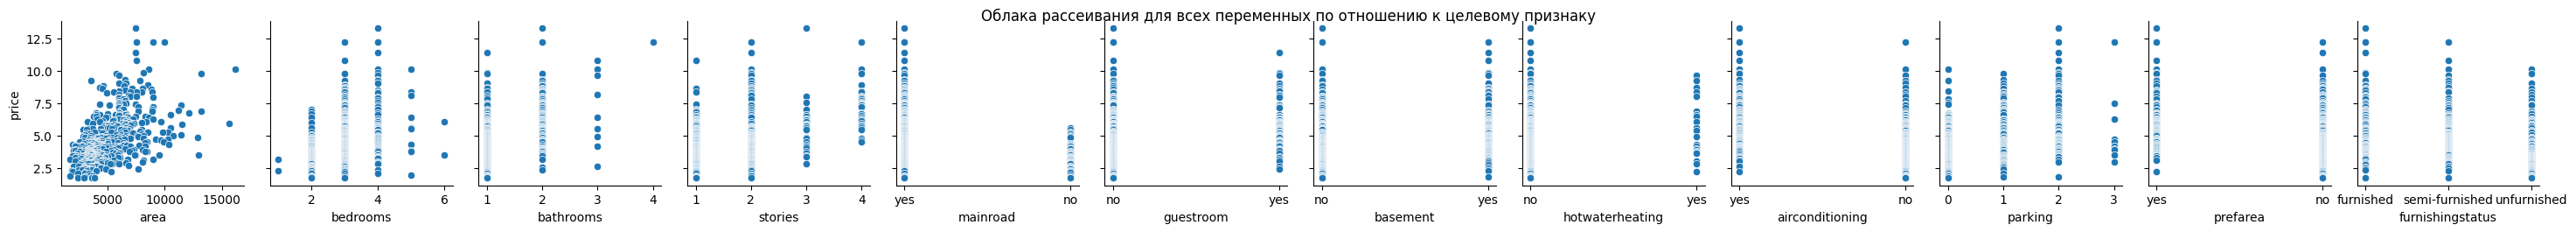

In [10]:
plt.figure(figsize=(12, 10))
sns.pairplot(df, y_vars=['price'], x_vars=df.columns.drop('price'), kind='scatter', diag_kind=None)
plt.suptitle('Облака рассеивания для всех переменных по отношению к целевому признаку', y=1.02)
plt.show()

**Исходя из представленных графиков можно сформировать гипотезы:**

**1)** Площадь дома влияет на стоимость (предполагается, что более крупные дома будут иметь более высокую стоимость);

**2)** Влияние предпочтительного района на стоимость (предполагается, что дома, расположенные в предпочтительном районе могут иметь более высокую стоимость);

**3)** Влияние количества спален на стоимость (предполагается, что чем больше количество комнат, тем выше стоимость дома)


*Далее посмотрим распределение площадей домов*

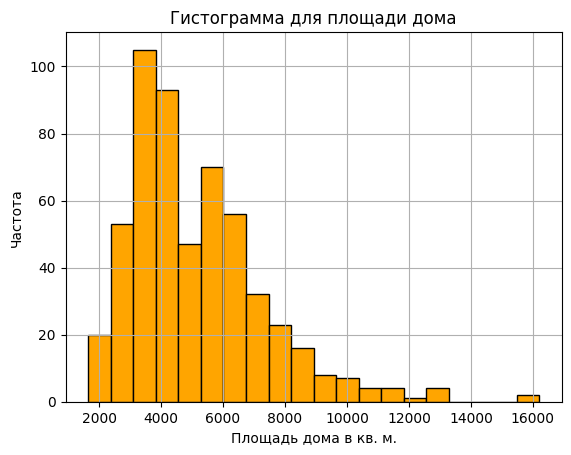

In [11]:
plt.hist(df['area'], bins=20, color='orange', edgecolor='black')
plt.title(f'Гистограмма для площади дома')
plt.xlabel('Площадь дома в кв. м.')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

**Вывод:** По графику видно, что распределение смещено влево и присутствуют выбросы

*Создаем сетку графиков для визуализации распределения значений различных категориальных переменных*

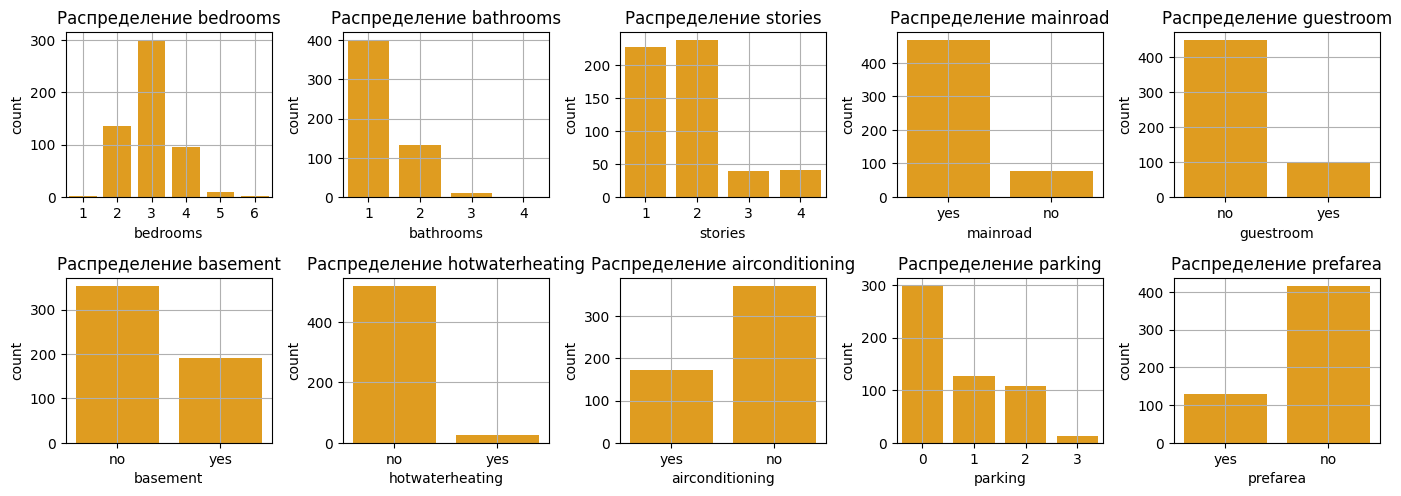

In [12]:
plt.figure(figsize=(14, 12))
for i, var in enumerate(df.columns.drop(['price', 'area', 'furnishingstatus'])):
    plt.subplot(5, 5, i+1)
    sns.countplot(x=var, data=df, color="orange")
    plt.title(f'Распределение {var}')
    plt.grid()

plt.tight_layout()
plt.show()

*Создаем диаграмму с распределением домов по наличию или отсутствию мебели*

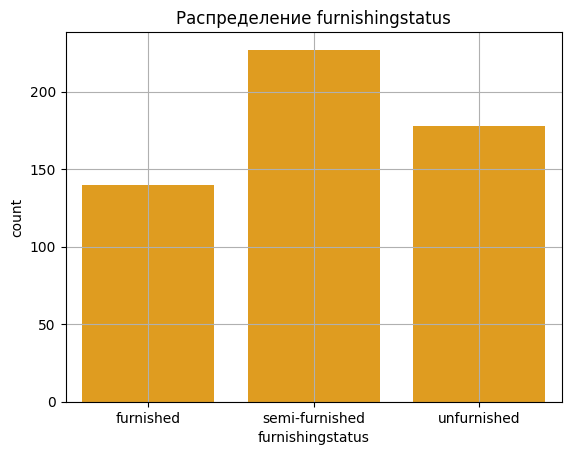

In [13]:
sns.countplot(x='furnishingstatus', data=df, color="orange")
plt.title(f'Распределение furnishingstatus')
plt.grid()

*Посмотрим, сколько квартир с 1 и 6 спальнями.*

In [15]:
df['bedrooms'].value_counts()

bedrooms
3    300
2    136
4     95
5     10
6      2
1      2
Name: count, dtype: int64

*Подсчитываем и возвращаем количество каждого уникального значения в столбце bedrooms DataFrame*

*Домов с 1 и 6 спальнями по 2 штуки, их можно добавить в категории c 2 и 5 спальнями соответственно.*

In [16]:
df.loc[df['bedrooms']==6, 'bedrooms'] = 5
df.loc[df['bedrooms']==1, 'bedrooms'] = 2

*Далее посмотрим на количество домов с 4 ванными комнатами.*

In [17]:
df['bathrooms'].value_counts()

bathrooms
1    401
2    133
3     10
4      1
Name: count, dtype: int64

Таких домов 1, поэтому отнесем его к 3 ванным комнатам.

In [18]:
df.loc[df['bathrooms']==4, 'bathrooms'] = 3

*Посмотрим на выбросы в площади домов*

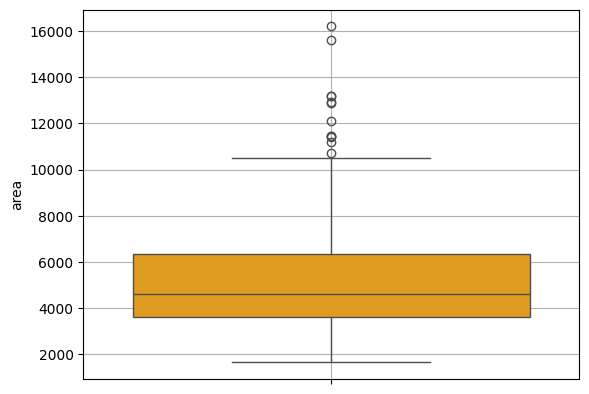

In [20]:
sns.boxplot(df['area'], color="orange")
plt.grid()

На графике видны аномалии, их стоит удалить, так как качество модели может испортиться

In [21]:
q3, q1 = np.percentile (df['area'], [75 ,25])
iqr = q3 - q1
df = df.loc[df['area'] < (1.5*iqr + q3)]

# Гипотезы

1) Площадь дома влияет на стоимость (предполагается, что более крупные дома будут иметь более высокую стоимость)

Нулевая гипотеза (Н0): Площадь дома не влияет на стоимость.

Альтернативная гипотеза (H1): Площадь дома влияет на стоимость.

In [22]:
corr, p_value = pearsonr(df['area'], df['price'])
print(f"Коэффициент корреляции Пирсона: {corr}")
print(f"P-значение: {p_value}")

Коэффициент корреляции Пирсона: 0.553689513115425
P-значение: 6.601871446483382e-44


P-value значительно меньше 0.05, поэтому есть основания отвергнуть нулевую гипотезу и принять альтернативную.


2) Влияние предпочтительного района на стоимость (предполагается, что дома, расположенные в предпочтительном районе могут иметь более высокую стоимость)

* `Нулевая гипотеза (Н0)`: Предпочтительность района не влияет на стоимость.

* `Альтернативная гипотеза (H1)`: Предпочтительность района влияет на стоимость.

In [23]:
t_stat, p_value = ttest_ind(df[df['prefarea'] == 'yes']['price'], df[df['prefarea'] == 'no']['price'])

formatted_t_stat = f"{t_stat:.4f}"
formatted_p_value = f"{p_value:.4e}"

print(f"t-статистика: {formatted_t_stat}")
print(f"P-значение: {formatted_p_value}")

alpha = 0.05
if p_value < alpha:
    print("Гипотеза о равенстве средних отвергается, есть статистически значимая разница между районами.")
else:
    print("Нет статистически значимой разницы между районами.")

t-статистика: 7.8269
P-значение: 2.7514e-14
Гипотеза о равенстве средних отвергается, есть статистически значимая разница между районами.


3) Влияние количества спален на стоимость (предполагается, что чем больше количество комнат, тем выше стоимость дома)

* `Нулевая гипотеза (Н0)`: Количество спален не влияет на стоимость.

* `Альтернативная гипотеза (H1)`: Количество спален влияет на стоимость.

In [24]:
prices_by_bedrooms = [df[df['bedrooms'] == b]['price'] for b in df['bedrooms'].unique()]

h_stat, p_value = kruskal(*prices_by_bedrooms) # Ниже поясняю зачем *
print(f"Краскел-Уоллис H-статистика: {h_stat:.4f}")
print(f"P-значение: {p_value:.4e}")

if p_value < alpha:
    print("Гипотеза о равенстве средних отвергается, есть статистически значимые различия между количеством спален.")
else:
    print("Нет статистически значимых различий между количеством спален.")

Краскел-Уоллис H-статистика: 90.9848
P-значение: 1.3459e-19
Гипотеза о равенстве средних отвергается, есть статистически значимые различия между количеством спален.


# Машинное обучение

*В данных есть признак "price", его и будем предсказывать. Соответственно, это задача регрессии. В качестве метрики будем использовать MAE.*

*Применим OHE кодирование категориальных признаков.*

In [25]:
cat = ['bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea', 'furnishingstatus']

encoder = OneHotEncoder()
encoder.fit(df[cat])
enc = encoder.transform(df[cat])

In [26]:
encoded_df = pd.DataFrame(enc.toarray(), columns = encoder.get_feature_names_out(cat))
encoded_df = pd.concat([df.drop(columns=cat).reset_index(drop=True), encoded_df], axis=1)
encoded_df

,price,area,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bathrooms_1,bathrooms_2,bathrooms_3,stories_1,...,airconditioning_yes,parking_0,parking_1,parking_2,parking_3,prefarea_no,prefarea_yes,furnishingstatus_furnished,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,13.30000,7420,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1,12.25000,8960,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
2,12.25000,9960,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,12.21500,7500,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
4,11.41000,7420,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525,1.82000,3000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
526,1.76715,2400,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
527,1.75000,3620,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
528,1.75000,2910,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [27]:
X = encoded_df.drop('price', axis=1)
y = encoded_df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
print(X_train.shape, X_test.shape)

(397, 31) (133, 31)


*Построим наивный прогноз, чтобы сравнивать его с результатами моделей.*

In [29]:
pred = np.full_like(y_train, y_train.mean())
print("Результат наивного прогноза: ", mean_absolute_error(y_train, pred))

Результат наивного прогноза:  1.4222739636695874


# Ridge регрессия

*Один из методов понижения размерности. Применим его для борьбы с переизбыточностью данных.*

In [30]:
params = {
    'alpha': [0.1, 1.0, 10.0],
    'fit_intercept': [True, False],
    'max_iter': [100, 500, 1000, None]}

model1 = GridSearchCV(Ridge(random_state=0), param_grid=params, cv=5, scoring='neg_mean_absolute_error')
model1.fit(X_train, y_train)
print("Лучшие параметры: ", model1.best_params_)
print("Лучший результат: ", - model1.best_score_)

Лучшие параметры:  {'alpha': 10.0, 'fit_intercept': True, 'max_iter': 100}
Лучший результат:  0.8015253655804322


# Случайный лес

*Метод, строит множество деревьев решений во время обучения и выводит класс в режиме классификации или среднее предсказание в режиме регрессий.*

In [31]:
params = {
    'n_estimators': [10, 50, 100],
    'max_depth': [3, 7, 16, None]}

model2 = GridSearchCV(RandomForestRegressor(random_state=0), param_grid=params, cv=5, scoring='neg_mean_absolute_error')
model2.fit(X_train, y_train)
print("Лучшие параметры: ", model2.best_params_)
print("Лучший результат: ", - model2.best_score_)

Лучшие параметры:  {'max_depth': 7, 'n_estimators': 100}
Лучший результат:  0.835516033679023


# LGBMRegressor

*Используется для построения прогнозных моделей.*

In [32]:
params = {
    'num_leaves' : [2, 10, 15, 31],
    'learning_rate' : [0.001, 0.01, 0.1],
    'max_depth': [3, 7, 16, -1]}

model3 = GridSearchCV(LGBMRegressor(force_row_wise=True, random_state=0), param_grid=params, cv=5, scoring='neg_mean_absolute_error')
model3.fit(X_train, y_train)
print("Лучшие параметры: ", model3.best_params_)
print("Лучший результат: ", - model3.best_score_)

Выходные данные были обрезаны до нескольких последних строк (5000).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

В итоге, все модели оказались лучше наивного прогноза, но предпочтения здесь стоит отдать Ridge регрессии. Поэтому будем использовать его для тестовых данных.

In [33]:
print("Результат на тестовых данных: ", mean_absolute_error(y_test, model1.predict(X_test)))

Результат на тестовых данных:  0.8543001679384703
